In [1]:
import os
from contextlib import contextmanager, nullcontext

from ax.utils.testing.mock import fast_botorch_optimize_context_manager
import plotly.io as pio

pio.renderers.default = "png"

SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_EVALS = 10 if SMOKE_TEST else 30

In [2]:
from typing import Optional

from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from torch import Tensor

class SimpleCustomGP(ExactGP, GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_X, train_Y, train_Yvar: Optional[Tensor] = None):
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [3]:
from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate

In [4]:
ax_model = BoTorchModel(
    surrogate = Surrogate(
        botorch_model_class = SimpleCustomGP, 
    ),
)

In [5]:
# from ax.modelbridge.registry import Models
# model_bridge = Models.BOTORCH_MODULAR(
#     experiment=experiment, 
#     data=data, 
#     surrogate=Surrogate(SimpleCustomGP), 
# )
# trial = model_bridge.gen(1)

In [6]:
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models

In [7]:
gs = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=5,  # How many trials should be produced from this generation step
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            model_kwargs={
                "surrogate": Surrogate(SimpleCustomGP),
            },
        ),
    ]
)

In [8]:
import torch
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from botorch.test_functions import Branin

ax_client = AxClient(generation_strategy=gs)
ax_client.create_experiment(
    name="branin_test_experiment",
    parameters=[
        {
            "name": "x1",
            "type": "range",
            # It is crucial to use floats for the bounds, i.e., 0.0 rather than 0.
            # Otherwise, the parameter would be inferred as an integer range.
            "bounds": [-5.0, 10.0],
        },
        {
            "name": "x2",
            "type": "range",
            "bounds": [0.0, 15.0],
        },
    ],
    objectives={
        "branin": ObjectiveProperties(minimize=True),
    },
)
branin = Branin()

def evaluate(parameters):
    x = torch.tensor([[parameters.get(f"x{i+1}") for i in range(2)]])
    # The GaussianLikelihood used by our model infers an observation noise level,
    # so we pass an sem value of NaN to indicate that observation noise is unknown
    return {"branin": (branin(x).item(), float("nan"))}

[INFO 01-03 14:09:28] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 01-03 14:09:28] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-03 14:09:28] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-03 14:09:28] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='x1', parameter_type=FLOAT, range=[-5.0, 10.0]), RangeParameter(name='x2', parameter_type=FLOAT, range=[0.0, 15.0])], parameter_constraints=[]).


In [9]:
if SMOKE_TEST:
    fast_smoke_test = fast_botorch_optimize_context_manager
else:
    fast_smoke_test = nullcontext

# Set a seed for reproducible tutorial output
torch.manual_seed(0)

In [10]:
for i in range(NUM_EVALS):
    parameters, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

[INFO 01-03 14:09:28] ax.service.ax_client: Generated new trial 0 with parameters {'x1': 0.62583, 'x2': 14.359564}.
[INFO 01-03 14:09:28] ax.service.ax_client: Completed trial 0 with data: {'branin': (104.365417, nan)}.
[INFO 01-03 14:09:28] ax.service.ax_client: Generated new trial 1 with parameters {'x1': 1.458453, 'x2': 14.529696}.
[INFO 01-03 14:09:28] ax.service.ax_client: Completed trial 1 with data: {'branin': (122.930588, nan)}.
[INFO 01-03 14:09:28] ax.service.ax_client: Generated new trial 2 with parameters {'x1': 9.140571, 'x2': 4.816245}.
[INFO 01-03 14:09:28] ax.service.ax_client: Completed trial 2 with data: {'branin': (7.390774, nan)}.
[INFO 01-03 14:09:28] ax.service.ax_client: Generated new trial 3 with parameters {'x1': 8.215463, 'x2': 9.037606}.
[INFO 01-03 14:09:28] ax.service.ax_client: Completed trial 3 with data: {'branin': (61.271847, nan)}.
[INFO 01-03 14:09:28] ax.service.ax_client: Generated new trial 4 with parameters {'x1': 9.934317, 'x2': 14.913237}.
[INFO

In [11]:
ax_client.get_trials_data_frame()

[WARNING 01-03 14:09:46] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


,trial_index,arm_name,trial_status,generation_method,branin,x1,x2
0,0,0_0,COMPLETED,Sobol,104.365417,0.625830,14.359564
1,1,1_0,COMPLETED,Sobol,122.930588,1.458453,14.529696
2,2,2_0,COMPLETED,Sobol,7.390774,9.140571,4.816245
3,3,3_0,COMPLETED,Sobol,61.271847,8.215463,9.037606
4,4,4_0,COMPLETED,Sobol,145.015671,9.934317,14.913237
5,5,5_0,COMPLETED,BoTorch,16.665329,7.924335,4.209484
6,6,6_0,COMPLETED,BoTorch,36.189003,-2.860520,5.658729
7,7,7_0,COMPLETED,BoTorch,28.414129,-1.552397,13.052577
8,8,8_0,COMPLETED,BoTorch,106.399918,8.005993,11.430383
9,9,9_0,COMPLETED,BoTorch,27.105564,0.326089,2.664652


In [12]:
parameters, values = ax_client.get_best_parameters()
print(f"Best parameters: {parameters}")
print(f"Corresponding mean: {values[0]}, covariance: {values[1]}")

Best parameters: {'x1': 9.52331608763457, 'x2': 2.6958747695908163}
Corresponding mean: {'branin': 0.30758931045746607}, covariance: {'branin': {'branin': 0.08138107564066469}}


[INFO 01-03 14:09:46] ax.service.ax_client: Retrieving contour plot with parameter 'x1' on X-axis and 'x2' on Y-axis, for metric 'branin'. Remaining parameters are affixed to the middle of their range.


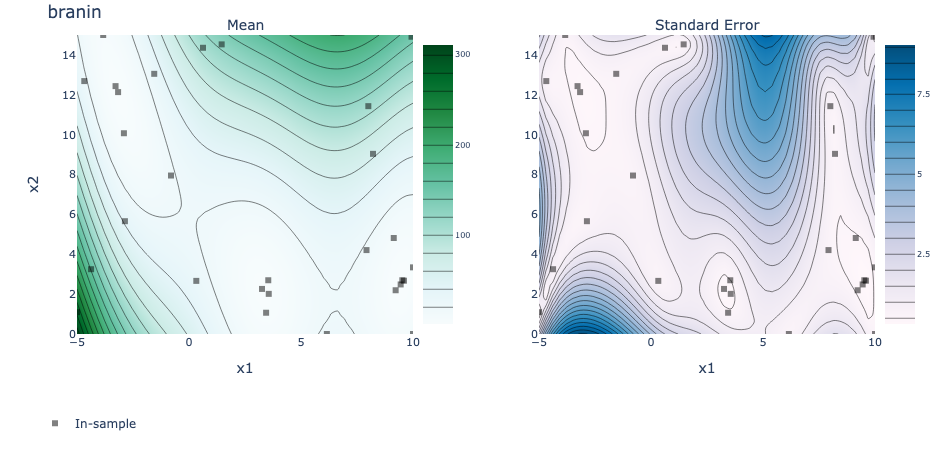

In [13]:
from ax.utils.notebook.plotting import render

render(ax_client.get_contour_plot())

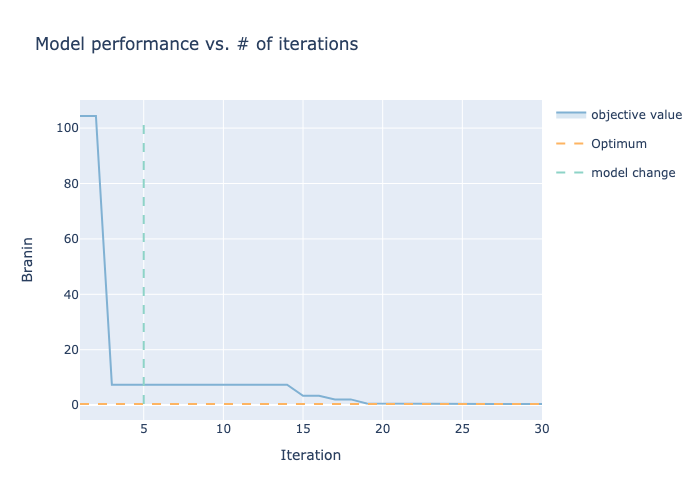

In [14]:
render(ax_client.get_optimization_trace(objective_optimum=0.397887))

In [20]:
!pip install -U kaleido